In [6]:
from common import Fonts, Images, NWSL, Colors, add_twitter_handle, add_source
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

In [167]:
df = pd.read_csv("teams.csv",index_col=[0])
df.columns = df.columns.astype(int)
df

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
team,,,,,,,,,,,
Boston Breakers,BOS,BOS,BOS,BOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FC Kansas City,KC,KC,KC,KC,UTA,UTA,UTA,UTA,KCC,KCC,KCC
Chicago Red Stars,CHI,NaN,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI
Portland Thorns,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR
Seattle Reign,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN
Sky Blue FC,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY
Washington Spirit,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS
Western New York Flash,WNY,WNY,WNY,WNY,NC,NC,NC,NC,NC,NC,NC
Houston Dash,NaN,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU


In [168]:
# Gather the list of cities for the y-axis
cities = pd.read_csv("cities.csv")


def city_to_y(c):
    if c == "KCC":
        c = "KC"
    return cities[cities["city"] == c].index[0]


cities

,city,name
0,BOS,Boston
1,KC,Kansas City
2,UTA,Salt Lake City
3,CHI,Chicago
4,POR,Portland
5,RGN,Seattle
6,NJNY,New Jersey
7,WAS,Washington DC
8,WNY,Rochester
9,NC,"Cary, NC"


In [169]:
# Gather the list of years for the x-axis
years = df.columns
years

Int64Index([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype='int64')

In [170]:
# Gather name labels
names = pd.read_csv("names.csv")
names["city_index"] = names["city"].apply(city_to_y)
names

,city,year,name,city_index
0,BOS,2013,Boston Breakers,0
1,KC,2013,FC Kansas City,1
2,CHI,2013,Chicago Red Stars,3
3,POR,2013,Portland Thorns,4
4,RGN,2013,Seattle Reign,5
5,NJNY,2013,Sky Blue FC,6
6,WAS,2013,Washington Spirit,7
7,WNY,2013,Western New York Flash,8
8,HOU,2014,Houston Dash,10
9,ORL,2016,Orlando Pride,11


In [171]:
# Helpers to interpolate lines as curves
def interpolate_base(cubic_p):
    x1 = 0
    y1 = 0
    x2 = 1
    y2 = 1
    steps = np.linspace(0, cubic_p, 10)
    x = list(map(lambda i: x1 + i, steps)) + list(map(lambda i: x2 - i, steps[::-1]))
    y = [y1] * len(steps) + [y2] * len(steps)
    f = interp1d(x, y, kind="quadratic")
    xs = np.linspace(x1, x2, num=40)
    ys = f(xs)

    return (xs, ys)


def interpolate(x1, y1, x2, y2):
    (xs, ys) = interpolate_base(0.1)
    for i in range(0, len(xs)):
        xs[i] = x1 + xs[i] * (x2 - x1)
        ys[i] = y1 + ys[i] * (y2 - y1)

    return (xs, ys)


def hex_to_RGB(hex_str):
    """#FFFFFF -> [255,255,255]"""
    # Pass 16 to the integer function for change of base
    return [int(hex_str[i : i + 2], 16) for i in range(1, 6, 2)]


def blend_colors(c1, c2):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    c1_rgb = np.array(hex_to_RGB(c1)) / 255
    c2_rgb = np.array(hex_to_RGB(c2)) / 255
    mix_pcts = interpolate_base(0.3)[1]
    rgb_colors = [((1 - mix) * c1_rgb + (mix * c2_rgb)) for mix in mix_pcts]
    return [
        "#" + "".join([format(int(round(val * 255)), "02x") for val in item])
        for item in rgb_colors
    ]


def to_points(x, y):
    c = list(map(lambda a: NWSL.color(a), y))
    y = list(map(city_to_y, y))

    x2, y2, c2 = [], [], []
    for xi, yi, ci in zip(x, y, c):
        if len(x2) == 0:
            x2.append(xi)
            y2.append(yi)
            c2.append(ci)
        else:
            xs, ys = interpolate(x2[-1], y2[-1], xi, yi)
            x2.extend(xs)
            y2.extend(ys)
            c2.extend(blend_colors(c2[-1], ci))
    return (x2, y2, c2)

<Figure size 5600x4000 with 0 Axes>

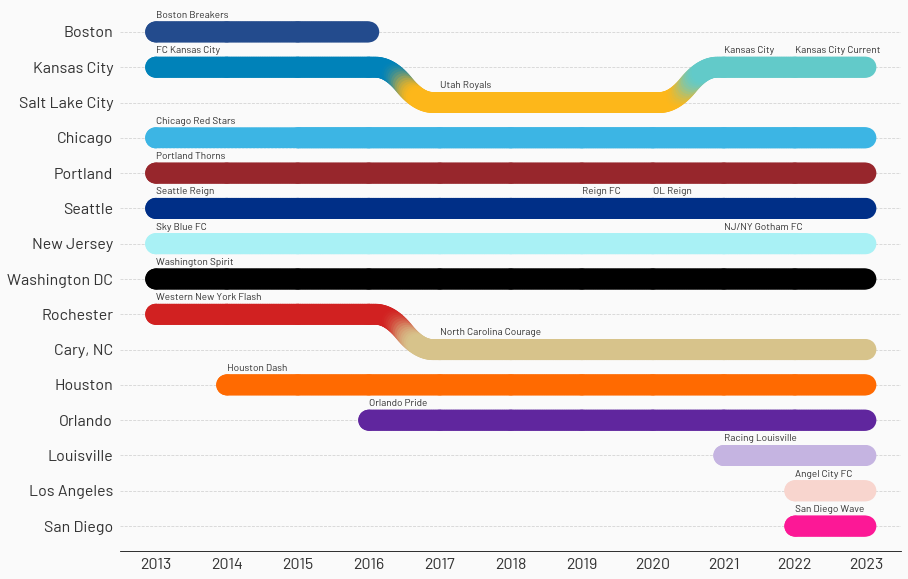

In [172]:
# Setup
plt.rcParams["figure.figsize"] = (14, 10)
plt.figure(dpi=400)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot data
for i, row in df.iterrows():
    row = row.dropna()
    x, y, c = to_points(row.index, row.values)
    ax.scatter(x, y, color=c, lw=15)

# Add team names
for i, row in names.iterrows():
    ax.text(
        row["year"],
        row["city_index"] - 0.4,
        row["name"],
        fontproperties=Fonts.BARLOW,
        color=Colors.BLACK,
    )

# Add axes
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)

    
ax.set_xticks(years)
ax.set_xticklabels(years, fontproperties=Fonts.BARLOW,
        size=16,
        color=Colors.BLACK,)

ax.set_yticks(cities.index)
ax.set_yticklabels(cities["name"], fontproperties=Fonts.BARLOW,
        size=16,
        color=Colors.BLACK,)
ax.invert_yaxis()
ax.yaxis.grid(True, color=Colors.LIGHT_GRAY, linestyle="--")